# **Federated Autoencoder**

### **i. Imports and subfunctions**

In [1]:
# Imports
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import Subset, DataLoader, random_split
from torch import nn
import torchvision 

# Subfunctions
def split_iid(dataset, n_centers):
    """
    Split PyTorch dataset randomly into n_centers.
    """
    n_obs_per_center = [len(dataset) // n_centers for _ in range(n_centers)]
    return random_split(dataset, n_obs_per_center)

def federated_averaging(models, n_obs_per_client):
    """
    Perform federated averaging.
    """
    # Error check inputs
    assert len(models) > 0
    assert len(n_obs_per_client) == len(models)

    # Compute proportions
    n_obs = sum(n_obs_per_client)
    proportions = [n_k / n_obs for n_k in n_obs_per_client]

    # Empty model parameter dictionary
    avg_params = models[0].state_dict()
    for key, val in avg_params.items():
        avg_params[key] = torch.zeros_like(val)

    # Compute average
    for model, proportion in zip(models, proportions):
        for key in avg_params.keys():
            avg_params[key] += proportion * model.state_dict()[key]

    # Copy one of the models and load trained params
    avg_model = copy.deepcopy(models[0])
    avg_model.load_state_dict(avg_params)

    return avg_model

### **ii. General setup**

In [2]:
# GPU settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

### **1. Create model**

In [3]:
# Autoencoder class
class AutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    
# Define model paramters and architecture
MyEncoder = AutoEncoder(input_shape=784).to(device)
optimizer = torch.optim.Adam(MyEncoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

### **2. Train model**

In [4]:
# Loop over training epochs
EPOCHS = 100
for epoch in range(EPOCHS):
    # Initialise loss
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = MyEncoder(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, EPOCHS, loss))

epoch : 1/100, loss = 0.032155
epoch : 2/100, loss = 0.018586
epoch : 3/100, loss = 0.016441
epoch : 4/100, loss = 0.015450
epoch : 5/100, loss = 0.014698
epoch : 6/100, loss = 0.014177
epoch : 7/100, loss = 0.013833
epoch : 8/100, loss = 0.013562
epoch : 9/100, loss = 0.013324
epoch : 10/100, loss = 0.013147
epoch : 11/100, loss = 0.012997
epoch : 12/100, loss = 0.012889
epoch : 13/100, loss = 0.012785
epoch : 14/100, loss = 0.012692
epoch : 15/100, loss = 0.012622
epoch : 16/100, loss = 0.012547
epoch : 17/100, loss = 0.012477
epoch : 18/100, loss = 0.012412
epoch : 19/100, loss = 0.012360
epoch : 20/100, loss = 0.012305
epoch : 21/100, loss = 0.012255
epoch : 22/100, loss = 0.012207
epoch : 23/100, loss = 0.012164
epoch : 24/100, loss = 0.012127
epoch : 25/100, loss = 0.012098
epoch : 26/100, loss = 0.012056
epoch : 27/100, loss = 0.012030
epoch : 28/100, loss = 0.012006
epoch : 29/100, loss = 0.011982
epoch : 30/100, loss = 0.011949
epoch : 31/100, loss = 0.011927
epoch : 32/100, l

### **3. Plot reconstructions**

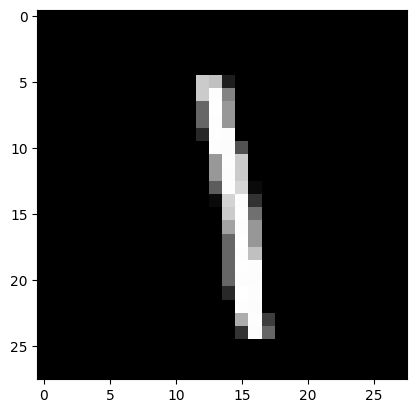

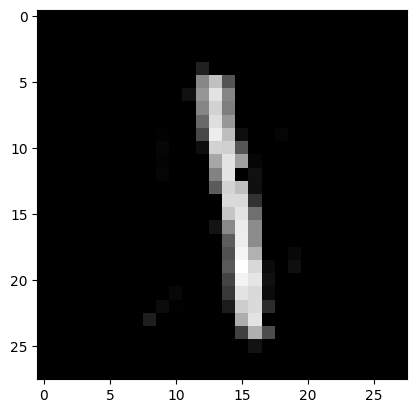

In [5]:
# Loop over test batch
for batch_test_features, _ in test_loader:
    test = batch_test_features.view(-1, 28, 28)
    test_1 = test[-1,:].numpy()    
    test_1_in = batch_test_features.view(-1, 784)[-1,:].to(device=device)
    plt.imshow(test_1, cmap='gray')
    plt.show()
    test_1_recon = MyEncoder.forward(test_1_in)
    test_1_recon = test_1_recon.view(28,28)
    test_1_recon = test_1_recon.cpu().detach().numpy()
    plt.imshow(test_1_recon, cmap='gray')
    plt.show()
    break


### **2. Create model and train**

In [ ]:
# Feature dimensions and dummy data
N_FEATURES = 784
dummy_data = [torch.zeros(1, N_FEATURES)]

# Model architecture
lat_dim = 3
vae_class = ThreeLayersVAE

In [ ]:
# VAE models
model = Mcvae(data=dummy_data, lat_dim=lat_dim, vaeclass=vae_class)
model.optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
model.init_loss()
# model = model.to(device=device)
models = [copy.deepcopy(model) for _ in range(N_CENTERS)]
n_obs_per_client = [len(client_data) for client_data in federated_dataset]

In [ ]:
# Initialise paramters
init_params = model.state_dict()

# Loop over training rounds and clients
for round_i in range(N_ROUNDS):
    for client_dataset, client_model in zip(federated_dataset, models):
        # Load client data in the form of a tensor
        X, y = get_data(client_dataset)
        # X = X.to(device=device)
        # y = y.to(device=device)
        client_model.data = [X.view(-1, N_FEATURES)]  # Set data attribute in client's model (list wraps the number of channels)

        # Load client's model parameters and train
        client_model.load_state_dict(init_params)
        client_model.optimize(epochs=N_EPOCHS, data=client_model.data)
        
    # Aggregate models using federated averaging
    trained_model = federated_averaging(models, n_obs_per_client)
    init_params = trained_model.state_dict()

### **3. Visualise results**